In [1]:
from qiskit import QuantumCircuit
import numpy as np
pi = np.pi
import itertools
from numbers import Number

from qiskit import Aer, execute
backend = Aer.get_backend('unitary_simulator')

/Users/MaoLin/psi4conda/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


# Introduction

In this notebook, we illustrate how to produce the quantum circuit for a given cost function of the following form

$
f({\bf x}) = {\bf x}^TQ{\bf x} + {\bf B}{\bf x}^T
$

where ${\bf x}$ is a $n\times 1$ vector of binary variables ($x_i=0,1$), and $Q$ is a $n\times n$ real symmetric matrix, and $B$ is a $1\times n$ real vector. 

To convert $f(x)$ to the Ising Hamiltonian, we perform the mapping (we adopt Dwave's convention here)

$
x_i\rightarrow \frac{1}{2}(\mathbb{I}+Z)_i,\quad i=1,...,n
$

for each binary variable. To understand this probably, let us consider a simple example. Suppose, we have ${\bf x}=(x_1,x_2,x_3)^T$, then we have

$
x_1\rightarrow \frac{\mathbb{I}+Z}{2}\otimes\mathbb{I}\otimes\mathbb{I}, \quad
x_2\rightarrow \mathbb{I}\otimes\frac{\mathbb{I}+Z}{2}\otimes\mathbb{I}, \quad
x_3\rightarrow \mathbb{I}\otimes\mathbb{I}\otimes\frac{\mathbb{I}+Z}{2}
$

In other word, each $x_i$ is represented by a tensor product of $n$ identity matrices, with the $i$-th one replaced by $(\mathbb{I}+Z)/2$. More generally, we use $U_i$ to denote a tensor product of $n$ identity matrices with the $i$-th one replaced by the matrix $U$. With these, we have

\begin{align}
&f({\bf x}) =\sum_{ij}x_iQ_{ij}x_j + \sum_iB_ix_i\\
\rightarrow&H_c= \sum_{ij}Q_{ij}\frac{(\mathbb{I}+Z)_i}{2}\frac{(\mathbb{I}+Z)_j}{2} + \sum_iB_i\frac{(\mathbb{I}+Z)_i}{2} \\
&\quad=\sum_{ij}\frac{1}{4}Q_{ij}Z_iZ_j + \frac{1}{2}\sum_i\left(\sum_jQ_{ij}+B_i\right)Z_i + \left(\frac{1}{4}\sum_{ij}Q_{ij}+\frac{1}{2}\sum_iB_i\right)\mathbb{I}\\
&\quad=\sum_{i<j}\frac{1}{2}Q_{ij}Z_iZ_j + \frac{1}{2}\sum_i\left(\sum_jQ_{ij}+B_i\right)Z_i + \left(\frac{1}{4}\sum_{ij}Q_{ij}+\frac{1}{2}\sum_iB_i+\frac{1}{4}\sum_iQ_{ii}\right)\mathbb{I}\\
\end{align}
where in the first term we have made use of the fact that $Q_{ij}$ is symmetric, and $Z_i$ commutes with $Z_j$.
Since the last term is a constant term, with no effect on the eigenstates, we shall ignore it. We are interested in constructing a quantum circuit corresponding to 

\begin{align}
U\equiv \exp\left(-i\gamma\sum_{i<j}\frac{1}{2}Q_{ij}Z_iZ_j\right)\exp\left(-i\gamma\frac{1}{2}\sum_i\left(\sum_jQ_{ij}+B_i\right)Z_i\right)\\
\end{align}
where we have made use the fact that the two terms in $H_c$ commute with each other. Thus, the order of the terms in the above unitary $U$ is irrelevant. We note that the $U$ operator consists of single qubit Z-rotation, as well as two-qubit Z-rotation. The construction of the former is easy, and more generally, the n-qubit Z-rotation, can be constructed as shown in the figure below. 

We say $H_c$ *represents* $f$ if it satisfies $H_f|x\rangle=f({\bf x})|x\rangle$ for $x\in\left\{0,1\right\}^n$ with the corresponding computational basis state $|x\rangle$. Similarly, we have $U|x\rangle=\exp(-i\gamma f({\bf x}))|x\rangle$, up to a global phase, as we shall show below.

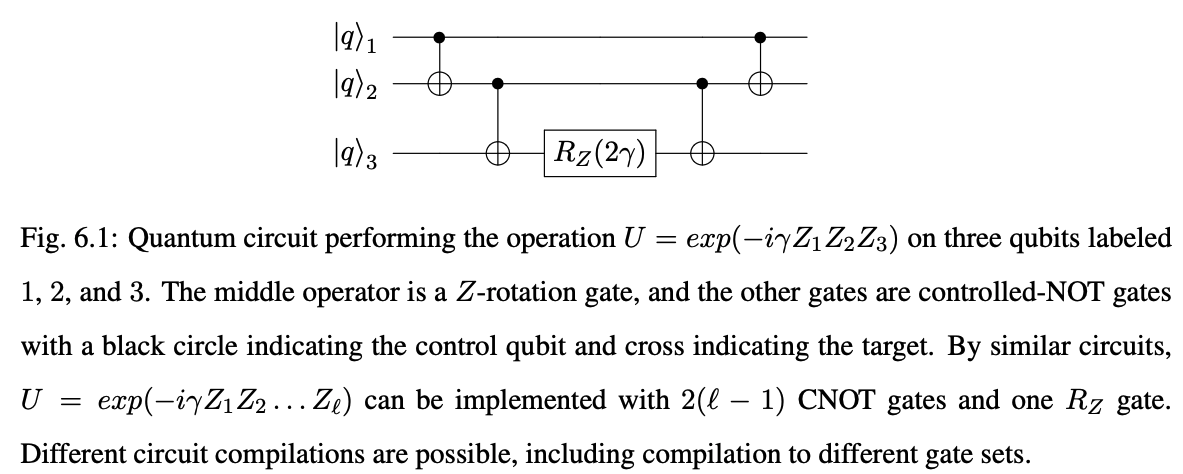





# Constructing the QUBO quantum circuit

Given the matrices $(Q, {\bf B})$, and the parameter $\gamma$, we construct the quantum circuit

In [2]:
def QUBO_circuit(gamma, Q, B):
    """Return a quantum circuit for given QUBO specified by the
    matrix Q, and vector B. gamma (γ above) is a given QAOA parameter. """
    
    n = len(Q) # number of qubits
    circ = QuantumCircuit(n)
    
    # Do a tiny validation
    if n != len(Q[0]) or n != len(B):
        raise("The dimension is not consistent")
        
    # Construct the quadratic part
    for i in range(n):
        for j in range(i+1, n):
            circ.cx(i,j)
            circ.rz(gamma * Q[i][j], j)
            circ.cx(i,j)
            
    # Construct the linear part
    coef = [sum(row)+B[i] for i, row in enumerate(Q)]
    for i in range(n):
        circ.rz(gamma * coef[i], i)
        
    return circ

In order to confirm that our quantum circuit is correct, we compare its eigenvalue spectrum to that of the cost function. 

In [3]:
def get_circ_phase(gamma, Q, B):
    """Get the eigenvalues of the unitary corresponding to the quantum circuit"""
    
    circ = QUBO_circuit(gamma, Q, B)
    result = execute(circ, backend).result()

    #get the unitary matrix from the result object
    mat = result.get_unitary(circ, decimals=10)
    mat_diag = np.diag(mat) 

    global_phase = 1/4 * sum([sum(row) for row in Q]) + 1/2 * sum(B) + 1/4 * sum([Q[i][i] for i in range(len(Q))])
    global_phase = np.exp(-1j * gamma * global_phase)

    mat_diag = mat_diag * global_phase
    
    return mat_diag

def get_f_phase(gamma, Q, B):
    """Get the spectrum of the QUBO cost function"""
    
    # Get the spectrum of f
    spec = []
    xs = list(itertools.product([0, 1], repeat=len(Q)))
    for x in xs:
        spec.append(0)
        for i in range(len(x)):
            for j in range(len(x)):
                spec[-1] += x[i] * Q[i][j] * x[j]
        for i in range(len(x)):
            spec[-1] += B[i] * x[i]

    exp_spec = np.exp(-1j * np.array(spec) * gamma)
    
    return exp_spec

# Example 1: Single binary variable

Let us test for a single variable variable where $f(x) = ax^2 + bx$. Since $x=0,1$, the two possible values for $f(x)$ are $0$ and $a+b$. Now, we expect that the quantum circuit represents $f(x)$ will have eigenvalues $\exp(-i\gamma 0)$ and $\exp(-i\gamma(a+b))$ up to a global phase. Thus, if we take the imagnary part of the log of the eigenvalues, followed by taking their difference and divided by $\gamma$, we should obtain $a+b$. This is indeed the case for the following circuit, as one can check.

In [16]:
a = np.random.rand()
b = np.random.rand()
gamma = np.random.rand()

Q = [[a]]
B = [b]

# print(f"Q={Q}")
# print(f"B={B}")
# print(f"gamma={gamma}")

circ = QUBO_circuit(gamma, Q, B)
circ.draw()

┌────────────┐
q_0: ┤ Rz(1.0693) ├
     └────────────┘

To confirm the eigenvalues, we obtain the matrix corresponds to the quantum circuit. 

In [5]:
mat_diag = get_circ_phase(gamma, Q, B)
exp_spec = get_f_phase(gamma, Q, B)
print(max(abs(np.sort(mat_diag)-np.sort(exp_spec))))

3.3387801970471046e-11


We see that indeed the eigenvalues of the quantum circuit correspond to the spectrum of $f(x)$

# Example 2: Two variables

Again, here we show that the eigenvalues of the quantum circuit $U$ correspond to the spectrum of $f(x)$. For that, we sort the eigenvalues of both, and figure out the offset between the lowest eigenvalue of $U$ and $f(x)$, which is nothing but the global phase. After eliminating that, the two spectrum match with each other. 

In [6]:
Q = np.random.rand(2,2)
Q = Q + Q.T
Q = Q

B = np.random.rand(1,2)[0] 
gamma = np.random.rand()

print(f"Q={Q}")
print(f"B={B}")
print(f"gamma={gamma}")

circ = QUBO_circuit(gamma, Q, B)
circ.draw()


Q=[[1.21201406 1.90985686]
 [1.90985686 0.31250122]]
B=[0.08181539 0.5357273 ]
gamma=0.6351745280104805


┌────────────┐
q_0: ──■──────────────────■──┤ Rz(2.0349) ├
     ┌─┴─┐┌────────────┐┌─┴─┐├────────────┤
q_1: ┤ X ├┤ Rz(1.2131) ├┤ X ├┤ Rz(1.7519) ├
     └───┘└────────────┘└───┘└────────────┘

In [7]:
mat_diag = get_circ_phase(gamma, Q, B)
exp_spec = get_f_phase(gamma, Q, B)
print(max(abs(np.sort(mat_diag)-np.sort(exp_spec))))

6.403343786554632e-11


# Example 3: General case

In [17]:
n = 3

Q = np.random.rand(n,n)
Q = Q + Q.T
Q = Q

B = np.random.rand(1,n)[0] 

gamma = np.random.rand()


# print(f"Q={Q}")
# print(f"B={B}")
# print(f"gamma={gamma}")

circ = QUBO_circuit(gamma, Q, B)

circ.draw()

┌────────────┐»
q_0: ──■───────────────────■────■───────────────────■──┤ Rz(1.5372) ├»
     ┌─┴─┐┌─────────────┐┌─┴─┐  │                   │  └────────────┘»
q_1: ┤ X ├┤ Rz(0.41893) ├┤ X ├──┼───────────────────┼────────■───────»
     └───┘└─────────────┘└───┘┌─┴─┐┌─────────────┐┌─┴─┐    ┌─┴─┐     »
q_2: ─────────────────────────┤ X ├┤ Rz(0.58405) ├┤ X ├────┤ X ├─────»
                              └───┘└─────────────┘└───┘    └───┘     »
«                                       
«q_0: ──────────────────────────────────
«                         ┌────────────┐
«q_1: ─────────────────■──┤ Rz(1.2119) ├
«     ┌─────────────┐┌─┴─┐├───────────┬┘
«q_2: ┤ Rz(0.28773) ├┤ X ├┤ Rz(1.079) ├─
«     └─────────────┘└───┘└───────────┘

In [18]:
mat_diag = get_circ_phase(gamma, Q, B)
exp_spec = get_f_phase(gamma, Q, B)
print(max(abs(np.sort(mat_diag)-np.sort(exp_spec))))

6.688942050801924e-11


# Extend to arbitrary order


We now consider a cost function for binary variables with arbitrary order, of the following form

\begin{align}
f({\bf x}) = \sum_{d=1}^{\text{dim}}\sum_{i_1,...,i_d=1}^nQ^{(d)}_{i_1,...,i_d}x_{i_1}...x_{i_d}
\end{align}
where there are $n$ binary variables, and $\text{dim}$ is the highest power for these binary variable. We shall refer to this as Polynomial order Unconstrainted Binary Optimization (PUBO). QUBO corresponds to PUBO with $\text{dim}=2$. We note that the coefficient tensor $Q^{(d)}_{i_1,...,i_d}$ is fully symmetric with respect to aribtrary permutations of their indices. For example, $Q^{(4)}_{ijkl}=Q^{(4)}_{ijlk}$. Using the mapping $x_i\rightarrow (\mathbb{I}+Z_i)/2$, we have
\begin{align}
&f({\bf x}) = \sum_{d=1}^{\text{dim}}\sum_{i_1,...,i_d=1}^nQ^{(d)}_{i_1,...,i_d}x_{i_1}...x_{i_d}\\
\rightarrow&H_c = \sum_{d=1}^{\text{dim}}\sum_{i_1,...,i_d=1}^nQ^{(d)}_{i_1,...,i_d}\frac{(\mathbb{I}+Z)_{i_1}}{2}...\frac{(\mathbb{I}+Z)_{i_d}}{2}
\end{align}
and the corresponding unitary is given as

\begin{align}
U\equiv \exp\left(-i\gamma H_c\right) = \prod_{d=1}^{\text{dim}}\prod_{i_1,...,i_d=1}^n\exp\left\{-i\gamma Q^{(d)}_{i_1,...,i_d}\frac{(\mathbb{I}+Z)_{i_1}}{2}...\frac{(\mathbb{I}+Z)_{i_d}}{2}\right\}
\end{align}
We aim to realize the quantum circuit corresponding to this unitary.


In [10]:
def get_PUBO_circ_from_Qs(gamma, *Qlist):
    """Construct the quantum circuit for a PUBO cost function
    specified by a Qlist, which contains the coefficient tensors.
    """
    
    def get_PUBO_dict(mydict, ind, Q):
        """Return a dictionary for a given tensor Q. 

        `mydict`, and `ind`, as an input, are {} and [] 
        respectively. The outcome is `mydict`, which is 
        a dictionary with each entry (1,...,m): θ 
        represents the following gate:

        $
        \exp(-i\theta Z_1...Z_m)
        $

        """

        def add_to_dict(ind, val):
            if ind not in mydict:
                mydict[ind] = val
            else:
                mydict[ind] += val

        if isinstance(Q, Number):
            ind = list(set(ind))
            indicies = list(itertools.product([0, 1], repeat=len(ind))) 

            for index in indicies:
                ind2 = list(np.where(np.array(index)==1)[0])
                ind4 = [ind[ind3] for ind3 in ind2]
                add_to_dict(frozenset(ind4), Q/(2**len(index)))

            return mydict

        for i in range(len(Q)):
            mydict = get_PUBO_dict(mydict, ind + [i], Q[i])

        return mydict   
    
    
    def get_PUBO_circ(circ, mydict, gamma):
        """Constuct the quantum circuit for a given dictionary for 
        quantum gates, and a prefactor gamma (γ).
        """

        for key, val in mydict.items():
            key = list(key)
            if len(key)>0:
                for i in range(len(key)-1):
                    circ.cx(key[i], key[i+1])
                circ.rz(2 * gamma * val, key[-1])
                for i in range(len(key)-1)[::-1]:
                    circ.cx(key[i], key[i+1])
        return circ    
    
    n = len(Qlist[0])
    mydict = {}
    for Q in Qlist:
        mydict = get_PUBO_dict(mydict, [], Q)
        
    circ = get_PUBO_circ(QuantumCircuit(n), mydict, gamma)
    
    return circ, mydict
    
    

## Test it for quadratic case

In [11]:
n = 3

Q = np.random.rand(n,n)
Q = Q + Q.T
Q = Q

B = np.random.rand(1,n)[0] 

gamma = np.random.rand()

circ, _ = get_PUBO_circ_from_Qs(gamma, Q, B)

# circ.draw()

mat_diag = get_circ_phase(gamma, Q, B)
exp_spec = get_f_phase(gamma, Q, B)
print(max(abs(np.sort(mat_diag)-np.sort(exp_spec))))

4.677976600487788e-11


We see that our new quantum circuit, which is meant for more general PUBO, works for QUBO.

## Test for more general cases

Let us now test for more general cases. First, we need to generate a fully symmetric tensor $Q_{i_1,...,i_d}$. Further, we have to be able to calculate the eigenvalue spectrum of the PUBO quantum circuit, as well as the PUBO cost function. 

In [12]:
def get_symmetric_tensor(n, dim):
    """Generate a fully symmetric tensor with dim indices, 
    and each index run from 0 to n-1, which is the number of 
    qubits. 
    """
    shape = [n] * dim
    indices = list(itertools.product(range(n), repeat=dim))
    
    mydict = {}
    array = []
    for ind in indices:
        ind2 = tuple(sorted(ind))
        if ind2 == ind:
            val = np.random.rand()
            mydict[ind] = val
            array.append(val)
        else:
            array.append(mydict[ind2])
    
    Q = np.reshape(array, shape)
    
    return Q


def get_circ_phase_PUBO(gamma, *Qlist):
    """Get the eigenvalues of the unitary corresponding to the PUBO quantum circuit"""
    
    circ, mydict = get_PUBO_circ_from_Qs(gamma, *Qlist)
    
    result = execute(circ, backend).result()

    #get the unitary matrix from the result object
    mat = result.get_unitary(circ, decimals=10)
    mat_diag = np.diag(mat) 
    
    global_phase = mydict[frozenset({})]
    global_phase = np.exp(-1j * gamma * global_phase)

    mat_diag = mat_diag * global_phase
    
    return mat_diag    


def get_f_phase_PUBO(gamma, *Qlist):
    """Get the spectrum for the PUBO cost function."""
    n = len(Qlist[0])
    # Get the spectrum of f
    spec = []
    xs = list(itertools.product([0, 1], repeat=n))
    
    def _get_f_phase_for_Q(Q, x):
        val = 0
        for i in range(len(Q)):
            if isinstance(Q[i], Number):
                return sum([i*j for i, j in zip(Q, x)])
            else:
                val += x[i] * _get_f_phase_for_Q(Q[i], x)
        return val
    
    for x in xs:
        spec.append(0)
        for Q in Qlist:
            spec[-1] += _get_f_phase_for_Q(Q, x)
    
    exp_spec = np.exp(-1j * np.array(spec) * gamma)
    
    return exp_spec    
    

We use the previous QUBO to test our `get_circ_phase_PUBO` and `get_f_phase_PUBO` functions.

In [13]:
mat_diag = get_circ_phase_PUBO(gamma, Q, B)
exp_spec = get_f_phase_PUBO(gamma, Q, B)
print(max(abs(np.sort(mat_diag)-np.sort(exp_spec))))

4.677987010124457e-11


Finally, we are ready to test the most PUBO case.

In [14]:
dim = 5 # highest order in the cost function
n = 4 # number of qubit 

Qlist = []

for d in range(1, dim+1):
    Qlist.append(get_symmetric_tensor(n, d))
    
gamma = np.random.rand()

circ, _ = get_PUBO_circ_from_Qs(gamma, *Qlist)

circ.draw()

┌────────────┐                                                     »
q_0: ┤ Rz(74.762) ├──■──────────────────■────■──────────────────■────■──»
     ├────────────┤┌─┴─┐┌────────────┐┌─┴─┐  │                  │    │  »
q_1: ┤ Rz(84.237) ├┤ X ├┤ Rz(45.077) ├┤ X ├──┼──────────────────┼────┼──»
     ├────────────┤└───┘└────────────┘└───┘┌─┴─┐┌────────────┐┌─┴─┐  │  »
q_2: ┤ Rz(84.906) ├────────────────────────┤ X ├┤ Rz(48.339) ├┤ X ├──┼──»
     ├───────────┬┘                        └───┘└────────────┘└───┘┌─┴─┐»
q_3: ┤ Rz(81.13) ├─────────────────────────────────────────────────┤ X ├»
     └───────────┘                                                 └───┘»
«                                                                        »
«q_0: ──────────────────────────────■─────────────────────────────────■──»
«                                   │                               ┌─┴─┐»
«q_1: ──────■───────────────────────┼────■────■──────────────────■──┤ X ├»
«         ┌─┴─┐     ┌────────────┐  │  ┌─┴─┐  │                  │  └───┘»
«q_2: ────┤ X ├─────┤ Rz(52.623) ├──┼──┤ X ├──┼──────────────────┼────■──»
«     ┌───┴───┴────┐└────────────┘┌─┴─┐└───┘┌─┴─┐┌────────────┐┌─┴─┐┌─┴─┐»
«q_3: ┤ Rz(43.709) ├──────────────┤ X ├─────┤ X ├┤ Rz(53.792) ├┤ X ├┤ X ├»
«     └────────────┘              └───┘     └───┘└────────────┘└───┘└───┘»
«                                                                            »
«q_0: ────────────────────────────────────────────■────■─────────────────────»
«                                               ┌─┴─┐┌─┴─┐                   »
«q_1: ─────────────────────■─────────────────■──┤ X ├┤ X ├──■────────────────»
«                        ┌─┴─┐┌───────────┐┌─┴─┐└───┘└───┘  │                »
«q_2: ────────────────■──┤ X ├┤ Rz(25.04) ├┤ X ├────────────┼────────────────»
«     ┌────────────┐┌─┴─┐└───┘└───────────┘└───┘          ┌─┴─┐┌────────────┐»
«q_3: ┤ Rz(53.732) ├┤ X ├─────────────────────────────────┤ X ├┤ Rz(24.539) ├»
«     └────────────┘└───┘                                 └───┘└────────────┘»
«                                                                              »
«q_0: ───────■────■────────────────────────────■───────────────────────────────»
«          ┌─┴─┐  │                            │                               »
«q_1: ──■──┤ X ├──┼────────────────────────────┼────■──────────────────────────»
«       │  └───┘┌─┴─┐                        ┌─┴─┐┌─┴─┐                        »
«q_2: ──┼───────┤ X ├──■──────────────────■──┤ X ├┤ X ├──■──────────────────■──»
«     ┌─┴─┐     └───┘┌─┴─┐┌────────────┐┌─┴─┐└───┘└───┘┌─┴─┐┌────────────┐┌─┴─┐»
«q_3: ┤ X ├──────────┤ X ├┤ Rz(27.009) ├┤ X ├──────────┤ X ├┤ Rz(32.547) ├┤ X ├»
«     └───┘          └───┘└────────────┘└───┘          └───┘└────────────┘└───┘»
«                                                      
«q_0: ───────■──────────────────────────────────────■──
«          ┌─┴─┐                                  ┌─┴─┐
«q_1: ──■──┤ X ├──■────────────────────────────■──┤ X ├
«     ┌─┴─┐└───┘┌─┴─┐                        ┌─┴─┐└───┘
«q_2: ┤ X ├─────┤ X ├──■──────────────────■──┤ X ├─────
«     └───┘     └───┘┌─┴─┐┌────────────┐┌─┴─┐└───┘     
«q_3: ───────────────┤ X ├┤ Rz(13.068) ├┤ X ├──────────
«                    └───┘└────────────┘└───┘

In [15]:
mat_diag = get_circ_phase_PUBO(gamma, *Qlist)
exp_spec = get_f_phase_PUBO(gamma, *Qlist)

print(max(abs(np.sort(mat_diag)-np.sort(exp_spec))))

6.902413166591048e-11


# Get the QAOA circuit for given Qlist

In [ ]:
def get_QAOA_circuit(p, gamma, *Qlist):
    circ, _ = get_PUBO_circ_from_Qs(gamma, *Qlist)

In [1]:
!python -V


Python 3.6.13 :: Anaconda, Inc.


In [20]:
conda update conda


Solving environment: done

## Package Plan ##

  environment location: /Users/MaoLin/psi4conda

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cffi-1.14.6                |   py36h2125817_0         215 KB
    jupyter_client-7.0.6       |     pyhd3eb1b0_0          90 KB
    pip-21.2.2                 |   py36hecd8cb5_0         1.8 MB
    prometheus_client-0.12.0   |     pyhd3eb1b0_0          47 KB
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following packages will be UPDATED:

  cffi                                1.14.5-py36h2125817_0 --> 1.14.6-py36h2125817_0
  jupyter_client                         7.0.1-pyhd3eb1b0_0 --> 7.0.6-pyhd3eb1b0_0
  pip                                 21.0.1-py36hecd8cb5_0 --> 21.2.2-py36hecd8cb5_0
  prometheus_client               

In [2]:
conda install anaconda


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /Users/MaoLin/psi4conda

  added / updated specs:
    - anaconda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _anaconda_depends-2019.10  |           py36_0           6 KB
    alabaster-0.7.12           |           py36_0          18 KB
    anaconda-custom            |           py36_1           3 KB
    anaconda-client-1.8.0      |   py36hecd8cb5_0         153 KB
    anaconda-project-0.10.2    |     pyhd3eb1b0_0         218 KB
    anyio-2.2.0                |   py36hecd8cb5_1         123 KB
    appdirs-1.4.4              |     pyhd3eb1b0_0          12 KB
    appscript-1.1.2            |   py36h9ed2024_0         132 KB
    a

lcms2-2.12           | 284 KB    | ##################################### | 100% 
pycrypto-2.6.1       | 378 KB    | ##################################### | 100% 
flask-2.0.2          | 78 KB     | ##################################### | 100% 
lz4-c-1.9.3          | 140 KB    | ##################################### | 100% 
pyflakes-2.4.0       | 60 KB     | ##################################### | 100% 
appscript-1.1.2      | 132 KB    | ##################################### | 100% 
bitarray-2.3.0       | 137 KB    | ##################################### | 100% 
mpmath-1.2.1         | 785 KB    | ##################################### | 100% 
snappy-1.1.8         | 54 KB     | ##################################### | 100% 
openpyxl-3.0.9       | 164 KB    | ##################################### | 100% 
mock-4.0.3           | 29 KB     | ##################################### | 100% 
mpc-1.1.0            | 84 KB     | ##################################### | 100% 
pytz-2021.3          | 171 K

In [2]:
conda install anaconda=2021.11


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                               failed

UnsatisfiableError: The following specifications were found
to be incompatible with the existing python installation in your environment:

Specifications:

  - anaconda=2021.11 -> python[version='3.7.11|3.8.12|3.9.7',build='h88f2d9e_1|h88f2d9e_0']

Your python: python=3.6

If python is on the left-most side of the chain, that's the version you've asked for.
When python appears to the right, that indicates that the thing on the left is somehow
not available for the python version you are constrained 

In [2]:
conda install python=3.8 anaconda=custom


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | 
Found conflicts! Looking for incompatible packages.
This can take several minutes.  Press CTRL-C to abort.
                                                                             \        -                                   |                                                                   failed

UnsatisfiableError: The following specifications were found to be incompatible with a past
explicit spec that is not an explicit spec in this operation (python):

  - anaconda=custom -> _anaconda_depends -> conda
  - anaconda=custom -> _anaconda_depends -> ipython
  - anaconda=custom -> _anaconda_depends -> jupyter
  - anaconda=custom -> _anaconda_depends -> python[version='2.7.*|3.6.*|3.7.

pyparsing -> python[version='>=3.6'] -> sqlite[version='>=3.20.1,<4.0a0|>=3.22.0,<4.0a0|>=3.23.1,<4.0a0|>=3.24.0,<4.0a0|>=3.25.2,<4.0a0|>=3.25.3,<4.0a0|>=3.26.0,<4.0a0|>=3.27.2,<4.0a0|>=3.29.0,<4.0a0|>=3.30.0,<4.0a0|>=3.30.1,<4.0a0|>=3.31.1,<4.0a0|>=3.32.3,<4.0a0|>=3.33.0,<4.0a0|>=3.35.4,<4.0a0|>=3.36.0,<4.0a0']
imageio -> python[version='>=3'] -> sqlite[version='>=3.20.1,<4.0a0|>=3.22.0,<4.0a0|>=3.23.1,<4.0a0|>=3.24.0,<4.0a0|>=3.25.2,<4.0a0|>=3.25.3,<4.0a0|>=3.26.0,<4.0a0|>=3.27.2,<4.0a0|>=3.29.0,<4.0a0|>=3.30.0,<4.0a0|>=3.30.1,<4.0a0|>=3.31.1,<4.0a0|>=3.32.3,<4.0a0|>=3.33.0,<4.0a0|>=3.35.4,<4.0a0|>=3.36.0,<4.0a0']
nbconvert -> python[version='>=3.8,<3.9.0a0'] -> sqlite[version='>=3.20.1,<4.0a0|>=3.22.0,<4.0a0|>=3.23.1,<4.0a0|>=3.24.0,<4.0a0|>=3.25.2,<4.0a0|>=3.25.3,<4.0a0|>=3.26.0,<4.0a0|>=3.27.2,<4.0a0|>=3.29.0,<4.0a0|>=3.30.0,<4.0a0|>=3.30.1,<4.0a0|>=3.31.1,<4.0a0|>=3.32.3,<4.0a0|>=3.33.0,<4.0a0|>=3.35.4,<4.0a0|>=3.36.0,<4.0a0']
jedi -> python[version='>=3.9,<3.10.0a0'] -> sqlite[v

setuptools -> python[version='>=3.10,<3.11.0a0'] -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0|>=6.3,<7.0a0']
json5 -> python -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0|>=6.3,<7.0a0']
sqlalchemy -> python[version='>=3.7,<3.8.0a0'] -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0']
cloudpickle -> python[version='>=3.6'] -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0|>=6.3,<7.0a0']
atomicwrites -> python -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0|>=6.3,<7.0a0']
distributed -> python[version='>=3.9,<3.10.0a0'] -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0|>=6.3,<7.0a0']
numpy -> python[version='>=3.8,<3.9.0a0'] -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0']
kiwisolver -> python[version='>=3.8,<3.9.0a0'] -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0']
pytz -> python -> ncurses[version='>=6.0,<7.0a0|>=6.1,<7.0a0|>=6.2,<7.0a0|>=6.3,<7.0a0']
testpath -> python[version='>=3.6'] -> ncurses

path -> python[version='>=3.6,<3.7.0a0'] -> openssl[version='1.0.*|>=1.0.2m,<1.0.3a|>=1.0.2n,<1.0.3a|>=1.0.2o,<1.0.3a|>=1.1.1a,<1.1.2a|>=1.1.1c,<1.1.2a|>=1.1.1d,<1.1.2a|>=1.1.1e,<1.1.2a|>=1.1.1g,<1.1.2a|>=1.1.1j,<1.1.2a|>=1.0.2l,<1.0.3a|>=1.1.1l,<1.1.2a|>=1.1.1k,<1.1.2a|>=1.1.1i,<1.1.2a|>=1.1.1h,<1.1.2a|>=1.1.1b,<1.1.2a']
decorator -> python -> openssl[version='1.0.*|>=1.0.2m,<1.0.3a|>=1.0.2n,<1.0.3a|>=1.0.2o,<1.0.3a|>=1.1.1a,<1.1.2a|>=1.1.1b,<1.1.2a|>=1.1.1c,<1.1.2a|>=1.1.1d,<1.1.2a|>=1.1.1e,<1.1.2a|>=1.1.1g,<1.1.2a|>=1.1.1h,<1.1.2a|>=1.1.1i,<1.1.2a|>=1.1.1j,<1.1.2a|>=1.1.1k,<1.1.2a|>=1.1.1l,<1.1.2a|>=1.0.2l,<1.0.3a|>=1.0.2p,<1.0.3a']
nbconvert -> python[version='>=3.8,<3.9.0a0'] -> openssl[version='1.0.*|>=1.0.2m,<1.0.3a|>=1.0.2n,<1.0.3a|>=1.0.2o,<1.0.3a|>=1.1.1a,<1.1.2a|>=1.1.1b,<1.1.2a|>=1.1.1c,<1.1.2a|>=1.1.1d,<1.1.2a|>=1.1.1e,<1.1.2a|>=1.1.1g,<1.1.2a|>=1.1.1j,<1.1.2a|>=1.1.1k,<1.1.2a|>=1.1.1l,<1.1.2a|>=1.1.1i,<1.1.2a|>=1.1.1h,<1.1.2a|>=1.0.2l,<1.0.3a|>=1.0.2p,<1.0.3a']
pydantic -

jupyterlab_server -> notebook[version='>=4.2.0'] -> nest-asyncio[version='>=1.5']
jupyter_server -> jupyter_client[version='>=6.1.1'] -> nest-asyncio[version='>=1.5']
nbconvert -> nbclient[version='>=0.5.0,<0.6.0'] -> nest-asyncio[version='>=1.5']
notebook -> nest-asyncio[version='>=1.5']
ipykernel -> jupyter_client[version='<8.0'] -> nest-asyncio[version='>=1.5']
_anaconda_depends -> jupyter_client -> nest-asyncio[version='>=1.5']
nbclient -> jupyter_client[version='>=6.1.5'] -> nest-asyncio[version='>=1.5']
qtconsole -> jupyter_client[version='>=4.1'] -> nest-asyncio[version='>=1.5']
nbclassic -> notebook[version='<7'] -> nest-asyncio[version='>=1.5']
nbclient -> nest-asyncio
spyder-kernels -> jupyter_client[version='>=5.3.4'] -> nest-asyncio[version='>=1.5']
jupyter_client -> nest-asyncio[version='>=1.5']

Package networkx conflicts for:
_anaconda_depends -> scikit-image -> networkx[version='>=1.0|>=1.8,<2.0|>=1.8|>=2.0']
networkx
anaconda=custom -> _anaconda_depends -> networkx
psi


Note: you may need to restart the kernel to use updated packages.
